In [12]:
import gensim
import os
import re
import numpy as np
import json as js
import argparse
import pandas as pd
import sklearn
import joblib
import torch
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from gensim.models import KeyedVectors
from transformers import BertTokenizer, BertModel



In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

#pooler_vector_np = pooler_vector.detach().numpy()

In [14]:
def BERTvectorizer(token):
    model = BertModel.from_pretrained("bert-base-uncased")

    encoded_input = []
    encoded_input = token
    if encoded_input.size(1)>512:
        half_size=encoded_input.size(1)//2
        encoded_input1=encoded_input[:,half_size:]
        encoded_input2=encoded_input[:,:half_size]
        output1=model(encoded_input1)
        output2=model(encoded_input2)
        pooler_vector1 = output1.pooler_output
        pooler_vector_np1 = pooler_vector1.detach().numpy()
        pooler_vector2 = output2.pooler_output
        pooler_vector_np2 = pooler_vector2.detach().numpy()
        pooler_vector_np = (pooler_vector1 + pooler_vector2)/2
    
    else: 
        output = model(encoded_input)
        pooler_vector = output.pooler_output
        pooler_vector_np = pooler_vector.detach().numpy()
        return pooler_vector_np[0]
    

In [15]:
def getPooler_vector(output):
    pooler_vector = []
    pooler_vector = output.pooler_output
    pooler_vector_np = pooler_vector.detach().numpy()
    return pooler_vector_np[0]
    

In [16]:
def getBERT_pooler_vector(tensor,model):
    output=model(tensor)
    pooler_vector = []
    pooler_vector = output.pooler_output
    pooler_vector_np = pooler_vector.detach().numpy()
    return pooler_vector_np[0]
    

In [17]:
def getDataJSON(route):
    with open(route,"r",encoding="utf-8") as f:
        result = [js.loads(jline.replace("diff","value")) for jline in f.read().splitlines()]
    return result

In [18]:
def getSize(tensor):
    tensorSize = tensor.size(1)
    #if tensor.size(1)>512:
        #tensor=tensor[:,:512]
    return tensorSize

In [19]:
def downsize(tensor):
    tensorSize = tensor.size(1)
    if tensor.size(1)>512:
        tensor=tensor[:,:512]
    return tensor

In [20]:
def shortPandas(serie,n):
    serie_acortada=serie[:n]
    return serie_acortada

In [28]:
def funcToPandas(serie,fun):
    serie_final = pd.Series(dtype=object)
    for tensor in serie:
        serie_final = serie_final.concat(pd.Series(fun(tensor)))

    return serie_final

In [32]:

def BERTProcessing(datadir,tokenizer,model):
    aux = os.path.join(datadir, "train.jsonl")
    data = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data[['text1','text2']] = pd.DataFrame(data.pair.tolist(), index= data.index)

    aux = os.path.join(datadir, "train_truth.jsonl")

    del data["pair"]
    data2 = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data = pd.merge(data,data2,how='outer',left_index=True,right_index=True)
    del data2

    n=50
    
    X_0 = data["text1"]
    X_0 = X_0.apply(tokenizer.encode, return_tensors="pt")
    X_0 = X_0.apply(downsize)
    X_0 = shortPandas(X_0,n)
    X_0 = X_0.apply(model)
    X_0 = X_0.apply(getPooler_vector)
    
    X_1 = data["text2"]
    X_1 = X_1.apply(tokenizer.encode, return_tensors="pt")
    X_1 = X_1.apply(downsize)
    X_1 = shortPandas(X_1,n)
    X_1 = X_1.apply(model)
    X_1 = X_1.apply(getPooler_vector)
    
    X = X_0 - X_1
    X = X.apply(np.absolute)
    Y = data["value"]
    print("$$$$$$-DONE-$$$$$$")
    return X,Y


In [33]:
data=BERTProcessing("../corpus/Pan23/dataset1/train/prepared/",tokenizer,model)

$$$$$$-DONE-$$$$$$


In [34]:
data[0]
Kelly    Philosophy

id
1-1-2       [0.056911767, 0.2450751, 0.049925447, 0.193844...
1-2-3       [0.114949465, 0.15786031, 0.08404046, 0.143449...
10-1-2      [0.0011026859, 0.09628391, 0.084511876, 0.1448...
10-2-3      [0.009160161, 0.14211923, 0.14014834, 0.260645...
10-3-4      [0.13378942, 0.07969952, 0.0016605854, 0.10876...
10-4-5      [0.030430198, 0.15404785, 0.02344501, 0.046777...
100-1-2     [0.0045509934, 0.0031840205, 0.09182894, 0.064...
100-2-3     [0.119838, 0.049634784, 0.04378724, 0.34092227...
100-3-4     [0.18972236, 0.11770648, 0.13893372, 0.1608553...
1000-1-2    [0.5926975, 0.079352796, 0.024208903, 0.363131...
1001-1-2    [0.46111664, 0.12208292, 0.6489401, 0.42565858...
1001-2-3    [0.18607008, 0.047218114, 0.7347167, 0.1899082...
1001-3-4    [0.034499407, 0.21977374, 0.03134674, 0.251057...
1002-1-2    [0.22296602, 0.00870496, 0.07210374, 0.0125848...
1002-2-3    [0.21242502, 0.0060340166, 0.035210192, 0.1854...
1003-1-2    [0.23022485, 0.045896977, 0.28070503, 0.019483...
1003-

In [11]:
data[0].max()

512

In [24]:

def plot_points_with_labels(vectors_df, labels_df):
  # Asegúrate de que las etiquetas y los vectores tengan el mismo índice
    labels_df.to_frame()
  # Separa los vectores según las etiquetas
    vectors_label_0 = vectors_df[labels_df == 0]
    vectors_label_1 = vectors_df[labels_df == 1]
    
  # Crea un gráfico de puntos
    plt.figure(figsize=(8, 6))
    plt.scatter(vectors_label_1.iloc[:, 0], vectors_label_1.iloc[:, 1], color='red', label='Con cambio')
    plt.scatter(vectors_label_0.iloc[:, 0], vectors_label_0.iloc[:, 1], color='blue', label='Sin cambio')
    
    
  # Configura las etiquetas y el título
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Embeddings Isomap')
   
  # Muestra la leyenda
    plt.legend()
   
  # Muestra el gráfico
    plt.show()

In [25]:
def redimencionarPCA(X):
    pca = PCA(n_components=2)
    X_vectores = X.apply(pd.Series)
    pca.fit(X_vectores.T)
    X_PCAvec = pd.DataFrame(pca.components_.T,index=X_vectores.index)
    return X_PCAvec


In [26]:
import matplotlib.pyplot as plt

/tmp/ipykernel_15630/4209396840.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vectors_label_0 = vectors_df[labels_df == 0]
/tmp/ipykernel_15630/4209396840.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vectors_label_1 = vectors_df[labels_df == 1]


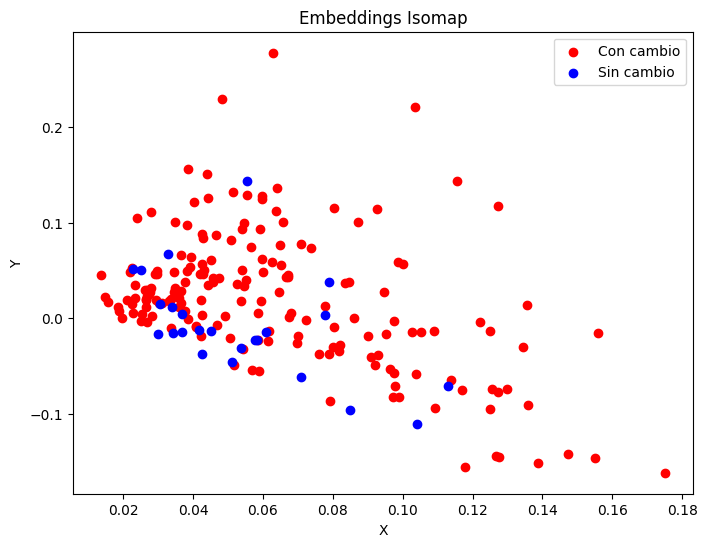

In [31]:
X_1=redimencionarPCA(data[0])
plot_points_with_labels(X_1,data[1])